In [1]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.metrics import confusion_matrix
from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Importing keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
np.random.seed(7)

### Colab config

In [3]:
# COLAB CONFIG
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True
COLAB_FILEPATH = './drive/My Drive/4034-amazon-review-classification-new/' if COLAB_FLAG == True else './'
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

# Pre-processing of data for training the model (Amazon dataset)

### Import training data

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect(COLAB_FILEPATH + 'data/database.sqlite')
data_train_raw_ = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

In [5]:
data_train_raw_.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
data_train_raw_.shape

(568454, 10)

# Filtering of the train data

### Remove duplicate entries

In [7]:
# check duplication of an entry
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
#Sorting data according to ProductId in ascending order
data_train_raw=data_train_raw_.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
# remove duplication of entries
data_train_raw=data_train_raw.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
data_train_raw.shape

(393933, 10)

In [10]:
data_train_raw.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."


In [11]:
# Checking to see how much % of data still remains
(data_train_raw['Id'].size*1.0)/(data_train_raw_['Id'].size*1.0)*100

69.29901100176971

In [12]:
# sample query
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
# choose data that the helpfulness numerator is higher than the denominator
data_train_raw=data_train_raw[data_train_raw.HelpfulnessNumerator<=data_train_raw.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(data_train_raw.shape)

# distribution of the score of the train data
data_train_raw['Score'].value_counts()

(393931, 10)


5    250966
4     56086
1     36307
3     29772
2     20800
Name: Score, dtype: int64

### Create a training dataframe with only the comments and the ratings

In [15]:
# create an empty dataframe
data_train = pd.DataFrame()

# to store only the required columns into the new dataframe
data_train['comments'] = data_train_raw['Text']
data_train['ratings'] = data_train_raw['Score']
data_train['type'] = "train"
data_train.head()

,comments,ratings,type
150528,In June<br />I saw a charming group<br />of ro...,4,train
150506,This is a fun way for children to learn their ...,4,train
150505,"I grew up reading these Sendak books, and watc...",4,train
150504,Get the movie or sound track and sing along wi...,4,train
150503,A very entertaining rhyming story--cleaver and...,4,train


In [16]:
data_train.shape

(393931, 3)

In [17]:
data_train.dtypes

comments    object
ratings      int64
type        object
dtype: object

There are 393931 data that we will use to train and validate our model, now we will move on to pre-process our test data, which was scraped from trip advisor.

# Pre-processing the test set (scraped data from tripadvisor)
The goal is to clean the data of the test set so that the both datasets have the same columns

### Import test data

In [18]:
# read the test data
data_test_raw_ = pd.read_csv(COLAB_FILEPATH+'data/trip-advisor-comments.csv')
data_test_raw_.head()

,Restaurant Name,Restaurant Type,Reviewer's Name,Rating,Comment
0,Positano @ RP,"Italian, European",aisvslife98,5,I enjoyed my time here with my girlfriends! Fa...
1,Positano @ RP,"Italian, European",Odyssey44198198885,5,Wonderful and amazing service experience. Defi...
2,Positano @ RP,"Italian, European",Ninifazelin,5,Great food and wonderful service! Will definit...
3,Positano @ RP,"Italian, European",Amaliamazlan,5,Not my first time in Positano and definitely w...
4,Positano @ RP,"Italian, European",Shahzanstim,5,Excellent service from the staff. The beef was...


In [19]:
data_test_raw_.shape

(97190, 5)

### Filtering of the test data

In [20]:
# remove duplication of entries
data_test_raw=data_test_raw_.drop_duplicates(subset={"Reviewer\'s Name","Rating","Comment"}, keep='first', inplace=False)
data_test_raw.shape

(88045, 5)

In [21]:
data_test_raw.head(3)

,Restaurant Name,Restaurant Type,Reviewer's Name,Rating,Comment
0,Positano @ RP,"Italian, European",aisvslife98,5,I enjoyed my time here with my girlfriends! Fa...
1,Positano @ RP,"Italian, European",Odyssey44198198885,5,Wonderful and amazing service experience. Defi...
2,Positano @ RP,"Italian, European",Ninifazelin,5,Great food and wonderful service! Will definit...


In [22]:
#Checking to see how much % of data still remains after removing duplications
(data_test_raw['Reviewer\'s Name'].size*1.0)/(data_test_raw_['Reviewer\'s Name'].size*1.0)*100

90.5905957403025

In [23]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(data_test_raw.shape)

# distribution of the score of the train data
data_test_raw['Rating'].value_counts()

(88045, 5)


5    46304
4    25978
3     8837
1     3464
2     3462
Name: Rating, dtype: int64

### Create a test dataframe with only the comments and the ratings

In [24]:
# create an empty dataframe
data_test = pd.DataFrame()

# to store only the required columns into the new dataframe
data_test['comments'] = data_test_raw['Comment']
data_test['ratings'] = data_test_raw['Rating']
data_test['type'] = "test"
data_test.head()

,comments,ratings,type
0,I enjoyed my time here with my girlfriends! Fa...,5,test
1,Wonderful and amazing service experience. Defi...,5,test
2,Great food and wonderful service! Will definit...,5,test
3,Not my first time in Positano and definitely w...,5,test
4,Excellent service from the staff. The beef was...,5,test


In [25]:
data_test.shape

(88045, 3)

In [26]:
data_test.dtypes

comments    object
ratings      int64
type        object
dtype: object

# Merge the 2 dataframes together
Take note of the last entry of the train set and the first entry of the test set so that we can split the dataset to train-val and test set after tokenization

In [27]:
# shape of train set
print(f'Train set dimension: {data_train.shape}')
# shape of test set
print(f'Test set dimension: {data_test.shape}')

Train set dimension: (393931, 3)
Test set dimension: (88045, 3)


In [28]:
# merge the 2 dataframes together to perform tokenization
frames = [data_train,data_test]
data_overall = pd.concat(frames)
data_overall.head()

,comments,ratings,type
150528,In June<br />I saw a charming group<br />of ro...,4,train
150506,This is a fun way for children to learn their ...,4,train
150505,"I grew up reading these Sendak books, and watc...",4,train
150504,Get the movie or sound track and sing along wi...,4,train
150503,A very entertaining rhyming story--cleaver and...,4,train


In [29]:
# check the dimension of the merged dataframe
data_overall.shape

(481976, 3)

In [30]:
# check the range where the data changes from train set to test set
# debug
#data_overall.iloc[:,:]
# finding the split
data_overall.iloc[393929:393933,:]

,comments,ratings,type
5702,Purchased this product at a local store in NY ...,5,train
327600,I purchased this to send to my son who's away ...,5,train
0,I enjoyed my time here with my girlfriends! Fa...,5,test
1,Wonderful and amazing service experience. Defi...,5,test


In [31]:
# last entry of the train set
data_overall.iloc[[393930]]

,comments,ratings,type
327600,I purchased this to send to my son who's away ...,5,train


In [32]:
# check dtypes of the merged dataframe
data_overall.dtypes

comments    object
ratings      int64
type        object
dtype: object

# Stemming and Lemmatization

In [33]:
import re

In [34]:
# remove contractions
def contraction_removal(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [35]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "\n"])

In [36]:
from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(data_overall['comments'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = contraction_removal(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 481976/481976 [02:20<00:00, 3432.96it/s]


In [37]:
data_overall['comments_cleaned'] = preprocessed_reviews
data_overall.head()

,comments,ratings,type,comments_cleaned
150528,In June<br />I saw a charming group<br />of ro...,4,train,junei saw charming groupof roses beginto droop...
150506,This is a fun way for children to learn their ...,4,train,fun way children learn months year learn poems...
150505,"I grew up reading these Sendak books, and watc...",4,train,grew reading sendak books watching really rosi...
150504,Get the movie or sound track and sing along wi...,4,train,get movie sound track sing along carol king gr...
150503,A very entertaining rhyming story--cleaver and...,4,train,entertaining rhyming story cleaver catchy illu...


In [38]:
data_overall.shape

(481976, 4)

# Partition the ratings to 3 classes only
-1 (negative) <- 1,2  
0 (neutral) <- 3  
1 (positive) <- 4,5


In [39]:
def partition(x):
    if x < 3:
        return -1
    elif x == 3:
        return 0
    else:   
        return 1

In [40]:
actualScore = data_overall['ratings']
class_ = actualScore.map(partition) 
data_overall['ratings_class'] = class_
print("Number of data points in our data", data_overall.shape)
data_overall.head(3)

Number of data points in our data (481976, 5)


,comments,ratings,type,comments_cleaned,ratings_class
150528,In June<br />I saw a charming group<br />of ro...,4,train,junei saw charming groupof roses beginto droop...,1
150506,This is a fun way for children to learn their ...,4,train,fun way children learn months year learn poems...,1
150505,"I grew up reading these Sendak books, and watc...",4,train,grew reading sendak books watching really rosi...,1


In [41]:
data_overall.dtypes

comments            object
ratings              int64
type                object
comments_cleaned    object
ratings_class        int64
dtype: object

In [42]:
data_overall['ratings_class'].value_counts()

 1    379334
-1     64033
 0     38609
Name: ratings_class, dtype: int64

# Export cleaned corpus to csv
To save the progress of the data cleaning at this point of time

In [43]:
data_overall.to_csv(COLAB_FILEPATH + 'data/data_overall_test_tripadvisor.csv', index=False)

# Import the cleaned corpus

In [44]:
data_overall_ = pd.read_csv(COLAB_FILEPATH + 'data/data_overall_test_tripadvisor.csv')
data_overall_.head()

,comments,ratings,type,comments_cleaned,ratings_class
0,In June<br />I saw a charming group<br />of ro...,4,train,junei saw charming groupof roses beginto droop...,1
1,This is a fun way for children to learn their ...,4,train,fun way children learn months year learn poems...,1
2,"I grew up reading these Sendak books, and watc...",4,train,grew reading sendak books watching really rosi...,1
3,Get the movie or sound track and sing along wi...,4,train,get movie sound track sing along carol king gr...,1
4,A very entertaining rhyming story--cleaver and...,4,train,entertaining rhyming story cleaver catchy illu...,1


In [45]:
data_overall_.dtypes

comments            object
ratings              int64
type                object
comments_cleaned    object
ratings_class        int64
dtype: object

In [47]:
data_overall['ratings_class'].value_counts()

 1    379334
-1     64033
 0     38609
Name: ratings_class, dtype: int64

In [ ]:
# change the dtypes of object to string for some columns
#data_overall = data_overall.astype({'comments_cleaned': 'string'})

In [48]:
data_overall_.count()

comments            481976
ratings             481976
type                481976
comments_cleaned    480958
ratings_class       481976
dtype: int64

In [49]:
# dropna for the row where the comments cleaned are empty
df = data_overall_.dropna()

In [50]:
# check
df.count()

comments            480958
ratings             480958
type                480958
comments_cleaned    480958
ratings_class       480958
dtype: int64

In [51]:
# remove not useful columns
data_overall = df.drop(labels='comments', axis=1)
data_overall = data_overall.drop(labels='ratings', axis=1)
data_overall.head(20)

,type,comments_cleaned,ratings_class
0,train,junei saw charming groupof roses beginto droop...,1
1,train,fun way children learn months year learn poems...,1
2,train,grew reading sendak books watching really rosi...,1
3,train,get movie sound track sing along carol king gr...,1
4,train,entertaining rhyming story cleaver catchy illu...,1
5,train,grand daughter favorite book read loves rhythm...,1
6,train,copy smaller expected mostly not pay attention...,1
7,train,remember seeing show aired television years ag...,1
8,train,book favorite mine since able read one first i...,1
9,train,wonderful little book loved years ago twins lo...,1


In [52]:
# check the range where the data changes from train set to test set
# debug
#data_overall.iloc[:,:]
# count number of dataset that belongs to train
data_overall['type'].value_counts()['train']

392915

In [53]:
# finding the split
data_overall.iloc[392914:392918,:]

,type,comments_cleaned,ratings_class
393930,train,purchased send son away college delivered righ...,1
393931,test,enjoyed time girlfriends fajar server gave rec...,1
393932,test,wonderful amazing service experience definitel...,1
393933,test,great food wonderful service definitely return...,1


In [54]:
data_overall.iloc[392914,1]

'purchased send son away college delivered right dorm room fast shipping loved much called thank sadly hardly ever calls anymore want kids call home good snack get midterms send'

# Label and define the predictor and the response

In [55]:
X = data_overall['comments_cleaned'].values
y = data_overall['ratings_class']
# one hot the classifier
y_oh = pd.get_dummies(y)

In [56]:
#X = data_train['comments'].values

In [57]:
# check the one-hot classifier
y_oh[:3]

,-1,0,1
0,0,0,1
1,0,0,1
2,0,0,1


In [58]:
X.dtype

dtype('O')

In [59]:
#X = X.astype('str')
#X.dtype

In [60]:
X

array(['junei saw charming groupof roses beginto droopi pepped upwith chicken soup sprinkle oncesprinkle twicesprinkle chicken soupwith ricethis great book teach children months year repetition phrases funny little stories accompanying pictures make ideal bedtime read not nearly good sendak books like wild things pierre boy not care still carries unique brand charm',
       'fun way children learn months year learn poems throughout school year like handmotions invent poem',
       'grew reading sendak books watching really rosie movie incorporates love son loves however miss hard cover version paperbacks seem kind flimsy takes two hands keep pages open',
       ...,
       'nice spacious restaurant sunlight thru roof cool nice place relax buffet spread variety dishes japanese cuisine northern indian western roast beef pork asian local favourites like laksa crayfish seafood spread covering',
       'restraunt replaces cafe swiss location chefs diff name good brewed coffee dilmah tea pla

In [61]:
pd.DataFrame(y_oh).head()

,-1,0,1
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [62]:
X_df = pd.DataFrame(X)
X_df.columns = ["cleaned_comments"]
X_df.head()

,cleaned_comments
0,junei saw charming groupof roses beginto droop...
1,fun way children learn months year learn poems...
2,grew reading sendak books watching really rosi...
3,get movie sound track sing along carol king gr...
4,entertaining rhyming story cleaver catchy illu...


In [ ]:
# Count the Vocabulary
count_vect = CountVectorizer()
count_vect.fit(X)

vocabulary = count_vect.get_feature_names()
print('Words in the Vocabulary : ',len(vocabulary))

Words in the Vocabulary :  135893


# Pre-processing of text by doing tokenization of data

In [ ]:
#Creating dictionary
corpus = dict()
ind = 0
for sent in X:
  for word in sent.split():
    corpus.setdefault(word,[])
    corpus[word].append(ind)
    ind += 1

#Frequency for each word of vocabulary
freq = []
for w in vocabulary:
  freq.append(len(corpus[w]))

In [ ]:
#Frequencies in decreasing order
inc_index =np.argsort(np.array(freq))[::-1]

#Allocating ranks 
word_rank = dict()
rank = 1
for i in inc_index:
  word_rank[vocabulary[i]] = rank
  rank +=1

In [ ]:
data = []
for sent in X:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)

In [ ]:
# check the tokenized representation
print(data[392914], end= ' ')

[189, 998, 398, 204, 2166, 659, 90, 7117, 751, 312, 162, 185, 18, 558, 345, 1750, 1591, 98, 2148, 765, 74, 248, 723, 210, 3, 138, 16, 66659, 998] 

In [ ]:
# splitting of data
X_train, X_test = data[:392915], data[392915:]
Y_train, Y_test = y[:392915], y[392915:]
Y_train_oh , Y_test_oh = y_oh[:392915], y_oh[392915:]

# Deep Learning Portion

In [ ]:
# padding input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[2000])

(392915, 100)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    50  1647  3092   600    15   381
    15   301    15   439   256  1031   232   156    52     7   958  1151
    98    26  9955  5094  8697 10961   386   447  1214  2002   316   817
    32  1308  2002   359   487   198   543     2   381  1849   152     2
     7    50   359    52  1111   255   156  5611    47  4960   147  1185
    55     7  3092  2526]


In [ ]:
Y_train_oh[:20]

,-1,0,1
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,0,0,1


In [ ]:
# plot function for the accuracy and loss curve
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()

### LSTM one layer

In [ ]:
vocab_size = len(vocabulary)
embedding_vector_length = 32
EPOCHS = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vector_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 32)           4348608   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 4,431,427
Trainable params: 4,431,427
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks_list=[ModelCheckpoint(filepath=COLAB_FILEPATH+'model/LSTM-1layer-3-class.h5',save_best_only=True,verbose=1,)]
#Fitting the data to the model
history = model.fit(X_train, 
                    Y_train_oh, 
                    epochs=EPOCHS, 
                    batch_size=512,
                    verbose=1,
                    #validation_data=(X_test, Y_test),
                    validation_split=0.2,
                    callbacks=callbacks_list)

Epoch 1/5
614/614 [==============================] - 45s 71ms/step - loss: 0.5218 - accuracy: 0.8218 - val_loss: 0.4411 - val_accuracy: 0.8366

Epoch 00001: val_loss improved from inf to 0.44108, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-1layer-3-class.h5
Epoch 2/5
614/614 [==============================] - 42s 69ms/step - loss: 0.3433 - accuracy: 0.8741 - val_loss: 0.4106 - val_accuracy: 0.8425

Epoch 00002: val_loss improved from 0.44108 to 0.41064, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-1layer-3-class.h5
Epoch 3/5
614/614 [==============================] - 42s 69ms/step - loss: 0.3078 - accuracy: 0.8855 - val_loss: 0.4203 - val_accuracy: 0.8437

Epoch 00003: val_loss did not improve from 0.41064
Epoch 4/5
614/614 [==============================] - 42s 68ms/step - loss: 0.2817 - accuracy: 0.8945 - val_loss: 0.4283 - val_accuracy: 0.8389

Epoch 00004: val_loss did not improve from 0.41064
Epoch 5/5
614/61

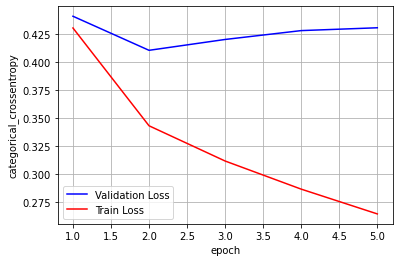

In [ ]:
#score = model.evaluate(X_test, Y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('categorical_crossentropy')

# list of epoch numbers
x = list(range(1,EPOCHS+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
# evaluate model with test set
#model.save(COLAB_FILEPATH+'model/LSTM-1layer.h5')
model_lstm_1layer = keras.models.load_model(COLAB_FILEPATH+'model/LSTM-1layer-3-class.h5')

# accuracy on test data
score_1layer = model_lstm_1layer.evaluate(X_test,Y_test_oh, verbose=0)
print('Test loss:', score_1layer[0]) 
print('Test accuracy:', score_1layer[1])

Test loss: 0.47899290919303894
Test accuracy: 0.8426677584648132


### Two LSTM layer

In [ ]:
vocab_size = len(vocabulary)
embedding_vector_length = 32
EPOCHS = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(128,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 32)           4348608   
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 128)          82432     
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 4,563,011
Trainable params: 4,563,011
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks_list=[ModelCheckpoint(filepath=COLAB_FILEPATH+'model/LSTM-2layer-3-class.h5',save_best_only=True,verbose=1,)]
#Fitting the data to the model
history = model.fit(X_train, 
                    Y_train_oh, 
                    epochs=EPOCHS, 
                    batch_size=512,
                    verbose=1,
                    #validation_data=(X_test, Y_test),
                    validation_split=0.2,
                    callbacks=callbacks_list)

Epoch 1/5
614/614 [==============================] - 487s 787ms/step - loss: 0.5085 - accuracy: 0.8243 - val_loss: 0.4325 - val_accuracy: 0.8361

Epoch 00001: val_loss improved from inf to 0.43251, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-2layer-3-class.h5
Epoch 2/5
614/614 [==============================] - 479s 780ms/step - loss: 0.3508 - accuracy: 0.8717 - val_loss: 0.4118 - val_accuracy: 0.8421

Epoch 00002: val_loss improved from 0.43251 to 0.41177, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-2layer-3-class.h5
Epoch 3/5
614/614 [==============================] - 481s 784ms/step - loss: 0.3199 - accuracy: 0.8814 - val_loss: 0.4112 - val_accuracy: 0.8449

Epoch 00003: val_loss improved from 0.41177 to 0.41121, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-2layer-3-class.h5
Epoch 4/5
614/614 [==============================] - 486s 792ms/step - loss: 0.2942 - accuracy: 0.890

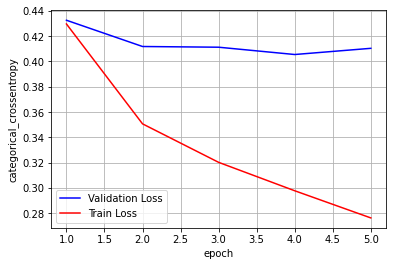

In [ ]:
#score = model.evaluate(X_test, Y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('categorical_crossentropy')

# list of epoch numbers
x = list(range(1,EPOCHS+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
# evaluate model with test set
#model.save(COLAB_FILEPATH+'model/LSTM-2layer.h5')
model_lstm_2layer = keras.models.load_model(COLAB_FILEPATH+'model/LSTM-2layer-3-class.h5')

# accuracy on test data
score_2layer = model_lstm_2layer.evaluate(X_test,Y_test_oh, verbose=0)
print('Test loss:', score_2layer[0]) 
print('Test accuracy:', score_2layer[1])

Test loss: 0.5000984072685242
Test accuracy: 0.846143364906311
